In [22]:
# Read our file of songs
# Read our CSV with ground truth
# Order songs based on our algortihm
# Compare optimized order to original order
# For each file of songs: Plot the error between predicted bpm and key and true bpm and key 

In [23]:
import sys
import os
sys.path.append('..')
print(os.getcwd())

from src.utilities.BPM import BPM_extractor
from src.utilities.predictKey import predict_key
from src.utilities.transition_cost import bpm_diff, key_diff, transition_cost
from src.utilities.playlist_optimizer import create_path_from_df

import  matplotlib.pyplot as plt 
from pydub import AudioSegment
import numpy as np 
import librosa
import pandas as pd
import os 

c:\Users\filip\Documents\Music Informatics\Music_project\notebooks


In [24]:

def get_sound(path):
    sound = AudioSegment.from_file(path)
    fs = sound.frame_rate
    if sound.channels == 2:
        sound = sound.set_channels(1)
    # normalize 
    audio = np.array(sound.get_array_of_samples())
    audio = audio / np.max(np.abs(audio))
    return audio, fs

In [25]:
def get_predictions(map_path, data_path, novelty, tempogram): 
    df = pd.read_csv(map_path)
    key_preds = []
    bpm_preds = []

    for i, row in df.iterrows():
        file_path = os.path.join(data_path, f"{row['name']}.mp3")
        audio, fs = get_sound(file_path)
        
        Extractor = BPM_extractor(
            fs,
            novelty=novelty,
            tempogram=tempogram,
            tempo_w=30, tempo_hop=3, novelty_w = 5.0, novelty_hop= 0.05 #0.3 is max, wonder why 
        )
        bpm = Extractor.get_BPM(audio, plot=False)
        bpm_preds.append(bpm)
        key=predict_key(file_path)
        key_preds.append(key)

    return bpm_preds, key_preds


Print true bpms and Keys with predicted bpms and Keys

In [26]:
map_path = "../data/638.csv"
data_path = "../data/David Guetta Playlist 638"
bpm_preds, keys_preds = get_predictions(map_path, data_path, "spectral", "fourier")

df_extended = pd.read_csv(map_path)
df_extended["predicted_bpm"] = bpm_preds
df_extended["predicted_key"] = keys_preds

df_extended.head(50)

,name,bpm,key,ix,predicted_bpm,predicted_key
0,Aracaju,125,11A,2,125.070403,8B
1,BLACK MAGIC,128,6B,9,127.803762,7A
2,Cameo - David Guetta Remix,126,8A,14,189.580078,10A
3,Carousel,128,9B,6,126.868786,6A
4,Counter Punch,126,9A,13,186.802559,6A
5,Crank,126,3B,4,125.976562,11A
6,Dance With Me,126,8B,3,125.720881,6A
7,Fuzzey - Da Fresh Remix,124,12A,7,183.314318,9A
8,Haunted,127,1B,10,123.748458,1B
9,I'm Good (Blue),128,6B,8,127.251519,6A


Plot BPM and Key prediction error based on transition cost functions

Average normalized bpm error: 0.3128760833890829
Average normalized key error: 0.3571428571428572


C:\Users\filip\AppData\Local\Temp\ipykernel_14504\3859128013.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


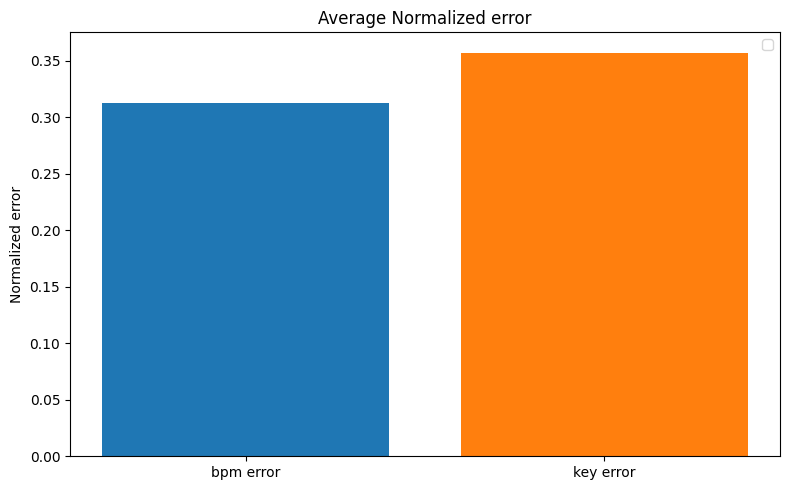

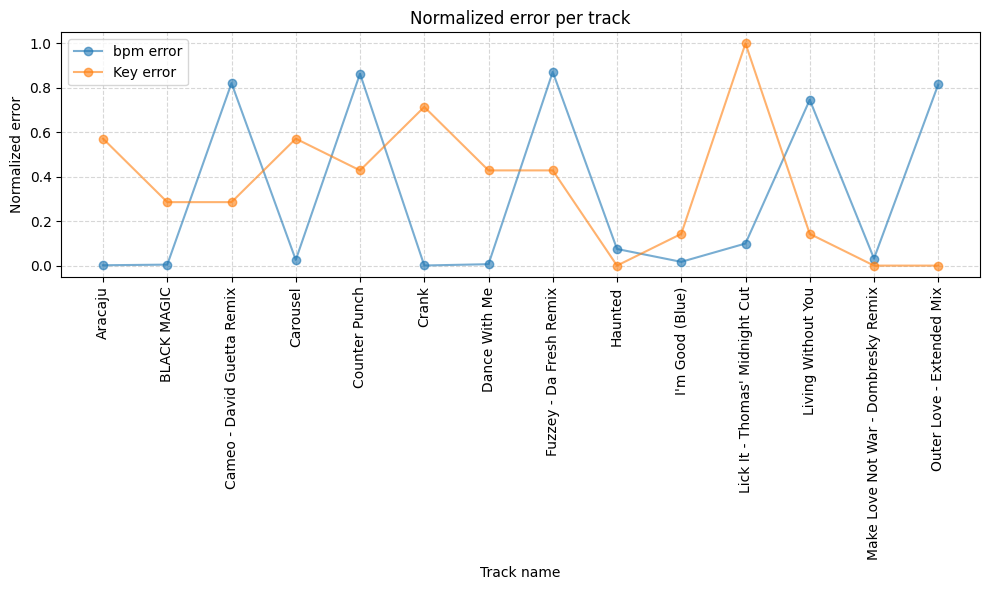

In [27]:
def plot_bpm_key_error(df):
    bpm_e = []
    key_e = []
    for i, row in df.iterrows():
        bpm_t = row["bpm"]; bpm_p = row["predicted_bpm"] 
        key_t = row["key"]; key_p = row["predicted_key"]
        bpm_e.append(bpm_diff(bpm_t, bpm_p))
        key_e.append(key_diff(key_t, key_p))

    df["bpm_dist"] = bpm_e
    df["key_dist"] = key_e

    # Plot average error per genre
    bpm_avg = df["bpm_dist"].mean()
    key_avg = df["key_dist"].mean()
    
    print(f"Average normalized bpm error: {bpm_avg}\nAverage normalized key error: {key_avg}")

    plt.figure(figsize=(8,5))
    plt.bar(['bpm error', 'key error'], [bpm_avg, key_avg], color=["tab:blue", "tab:orange"])
    plt.ylabel("Normalized error")
    plt.legend()
    plt.title("Average Normalized error")
    plt.tight_layout()
    plt.show()

    # Plot per-track error
    plt.figure(figsize=(10,6))
    plt.plot(df["bpm_dist"], alpha=0.6, label="bpm error", color="tab:blue", marker='o')
    plt.plot(df["key_dist"], alpha=0.6, label="Key error", color="tab:orange", marker='o')
    plt.xticks(range(len(df['name'])), df["name"], rotation=90)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.ylabel("Normalized error")
    plt.xlabel("Track name")
    plt.title("Normalized error per track")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
plot_bpm_key_error(df_extended)

Calculate optimized song order and compare with original order

In [56]:
df_prediction = df_extended[['name', 'predicted_bpm', 'predicted_key']]
df_reference = df_extended[['name', 'bpm', 'key', 'ix']]
df_prediction.columns = ['name', 'bpm', 'key']

ordered_perm, cost = create_path_from_df(df_prediction)

df_ordered_p = df_prediction.iloc[ordered_perm].reset_index(drop=True)

# Ordering the reference set
df_ordered_r = df_reference.sort_values(by='ix')
reference_perm = df_ordered_r.index.tolist()


In [57]:
total_cost_p = cost
total_cost_r = sum([transition_cost(df_ordered_r.iloc[i], df_ordered_r.iloc[i+1]) for i in range(len(df_ordered_r)-1)])
print("Total cost reference order:", total_cost_r)
print("Total cost optimized order:", total_cost_p)

print(reference_perm, ordered_perm)

pd.concat([df_ordered_r['name'], df_ordered_p['name']], axis=1).reset_index(drop=True).head(20)

Total cost reference order: 3.1932787971211556
Total cost optimized order: 2.915271822723472
[11, 0, 6, 5, 10, 3, 7, 9, 1, 8, 13, 12, 4, 2] [0, 5, 12, 8, 13, 11, 2, 7, 4, 10, 9, 3, 6, 1]


,name,name
0,Living Without You,Carousel
1,Aracaju,Aracaju
2,Dance With Me,Cameo - David Guetta Remix
3,Crank,Living Without You
4,Lick It - Thomas' Midnight Cut,I'm Good (Blue)
5,Carousel,Haunted
6,Fuzzey - Da Fresh Remix,Fuzzey - Da Fresh Remix
7,I'm Good (Blue),Lick It - Thomas' Midnight Cut
8,BLACK MAGIC,Crank
9,Haunted,Counter Punch


In [65]:
from scipy.stats import kendalltau, spearmanr

corr_kendall, _ = kendalltau(ordered_perm, reference_perm)

corr_spearmanr, _ = spearmanr(ordered_perm, reference_perm)

print(f"Kendall Tau correlation: {round(corr_kendall*100, 3)}%")
print(f"Spearman correlation: {round(corr_spearmanr*100, 3)}%")



Kendall Tau correlation: 9.89%
Spearman correlation: 10.33%


In [61]:
for i in range(len(perm) - 1):
    (index1, index2) = (perm[i], perm[i+1])
    song1 = df_ordered_r.iloc[index1]
    song2 = df_ordered_r.iloc[index2]
    cost = cost_matrix.get_cost(index1, index2) # Get cost from class method to avoid more calculations
    ordered_songs.append({
        "from": song1["song"],
        "to": song2["song"],
        "cost": cost
    })

ordered_df = pd.DataFrame(ordered_songs)

print(f"The total transition cost of the ordered songs (using simulated annealing) is: {cost_diff}% smaller than the unordered")

plt.figure(figsize=(12, 5))
plt.plot(ordered_df["cost"], marker="o")
plt.xticks(range(len(ordered_df)), cost_df["to"], rotation=90)
plt.title("Transition Cost Between Ordered Songs (Heuristic TSP)")
plt.xlabel("Song Transition")
plt.ylabel("Cost")
plt.grid(True, linestyle='--', alpha=0.5)
plt.text(0.02, 15, f"Total Cost: {total_cost:.2f}")
plt.show()

NameError: name 'cost_matrix' is not defined